**Copyright 2019 The Sonnet Authors. All Rights Reserved.**

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or  implied.
See the License for the specific language governing permissions and
limitations under the License.

---

## Generative Adversarial Networks (GANs)

In this notebook we'll use Sonnet 2 and TensorFlow 2 to train a small image generator using the Generative Adversarial Nets (GAN) [1] framework. GANs consist of two modules:

1.   A **generator**, which takes randomly sampled noise or latents as inputs and produces data (in this case, images) as output.
2.   A **discriminator**, which provides the learning signal for the generator. Its inputs are real images and generated images, and it's trained to predict whether each input is real or generated.  The generator is trained to "fool" the discriminator into believing its outputs are real.

Typically both the generator and discriminator are deep neural networks.

For an extended tutorial on GANs, see Ian Goodfellow's [GAN Tutorial](https://arxiv.org/abs/1701.00160) [2].

[1] I. Goodfellow, J. Pouget-Abadie, M. Mirza, B. Xu, D. Warde-Farley, S. Ozair, A. Courville, and Y. Bengio. [Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf). *NeurIPS*, 2014.

[2] I. Goodfellow. [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160). *arXiv:1701.00160*, 2017.

# Preamble

In [0]:
import sys
assert sys.version_info >= (3, 6), "Sonnet 2 requires Python >=3.6"

In [2]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
!pip install dm-sonnet==2.0.0b0 gast==0.2.2 tqdm

In [0]:
import functools
import time
import numpy as np
import sonnet as snt
import tensorflow as tf
import tensorflow_datasets as tfds
import tqdm

In [5]:
print("TensorFlow version: {}".format(tf.__version__))
print("    Sonnet version: {}".format(snt.__version__))

TensorFlow version: 2.0.0-rc1
    Sonnet version: 2.0.0b0


Finally lets take a quick look at the GPUs we have available:

In [6]:
!grep Model: /proc/driver/nvidia/gpus/*/information | awk '{$1="";print$0}'

 Tesla T4


# Dataset

We need to get our dataset in a state where we can iterate over it easily. The TensorFlow Datasets package provides a simple API for this. It will download the dataset and prepare it for us to speedily process on a GPU. We can also add our own pre-processing functions to mutate the dataset before our model sees it:

In [0]:
def process_batch(images, labels):
  images = tf.squeeze(images, axis=[-1])
  images = tf.cast(images, dtype=tf.float32)
  images /= 255.
  images = tf.clip_by_value(images, 0., 1.)
  return images, labels

batch_size = 100
def mnist(split, batch_size=batch_size):
  dataset, ds_info = tfds.load('mnist', split=split, as_supervised=True,
                               with_info=True)
  dataset = dataset.map(process_batch)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  dataset = dataset.cache()
  return dataset, ds_info

mnist_train, mnist_train_info = mnist('train')
mnist_test, mnist_test_info = mnist('test')

mnist_shuffled = mnist_train.shuffle(10000).repeat()

MNIST contains `28x28` greyscale handwritten digits. Let's take a look at one:

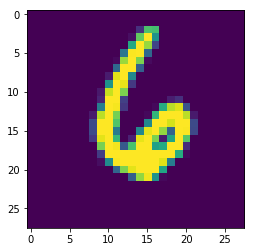

In [8]:
import matplotlib.pyplot as plt

images, _ = next(iter(mnist_test))
plt.imshow(images[0])

# Sonnet

The next step is to define a model. In Sonnet everything that contains TensorFlow variables (`tf.Variable`) extends `snt.Module`, this includes low level neural network components (e.g. `snt.Linear`,  `snt.Conv2D`), larger nets containing subcomponents (e.g. `snt.nets.MLP`), optimizers (e.g. `snt.optimizers.Adam`) and whatever else you can think of.

Modules provide a simple abstraction for storing parameters (and `Variable`s used for other purposes, like for storing moving averages in `BatchNorm`).

To find all the parameters for a given module, simply do: `module.variables`. This will return a `tuple` of all the parameters that exist for this module, or any module it references:

## Building the model

In Sonnet you build neural networks out of `snt.Module`s. In this simple example we'll build multi-layer perceptron (MLP) based generators and discriminators.

We'll make use of "Spectral Normalization" [1] in both modules, which serves to regularize them.

[1] T. Miyato, T. Kataoka, M. Koyama, and Y. Yoshida. [Spectral Normalization for Generative Adversarial Networks](https://arxiv.org/abs/1802.05957). *arXiv:1802.05957*, 2018.

In [0]:
class SpectralNormalizer(snt.Module):

  def __init__(self, epsilon=1e-12, name=None):
    super().__init__(name=name)
    self.l2_normalize = functools.partial(tf.math.l2_normalize, epsilon=epsilon)

  @snt.once
  def _initialize(self, weights):
    init = self.l2_normalize(snt.initializers.TruncatedNormal()(
        shape=[1, weights.shape[-1]], dtype=weights.dtype))
    # 'u' tracks our estimate of the first spectral vector for the given weight.
    self.u = tf.Variable(init, name='u', trainable=False)

  def __call__(self, weights, is_training=True):
    self._initialize(weights)
    if is_training:
      # Do a power iteration and update u and weights.
      weights_matrix = tf.reshape(weights, [-1, weights.shape[-1]])
      v = self.l2_normalize(self.u @ tf.transpose(weights_matrix))
      v_w = v @ weights_matrix
      u = self.l2_normalize(v_w)
      sigma = tf.stop_gradient(tf.reshape(v_w @ tf.transpose(u), []))
      self.u.assign(u)
      weights.assign(weights / sigma)
    return weights


class SpectrallyNormedLinear(snt.Linear):

  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.spectral_normalizer = SpectralNormalizer()

  def __call__(self, inputs, is_training=True):
    self._initialize(inputs)

    normed_w = self.spectral_normalizer(self.w, is_training=is_training)
    outputs = tf.matmul(inputs, normed_w)
    if self.with_bias:
      outputs = tf.add(outputs, self.b)
    return outputs


class SimpleBlock(snt.Module):

  def __init__(self, embed_dim, with_batch_norm=False, name=None):
    super().__init__(name=name)
    self.embed_dim = embed_dim
    self.hidden = SpectrallyNormedLinear(self.embed_dim)
    if with_batch_norm:
      self.bn = snt.BatchNorm(create_scale=True, create_offset=True)
    else:
      self.bn = None

  def __call__(self, inputs, is_training=True):
    output = self.hidden(inputs, is_training=is_training)
    if self.bn:
      output = self.bn(output, is_training=is_training)
    output = tf.nn.relu(output)
    return output


class Generator(snt.Module):

  def __init__(self, output_shape, num_layers=1, embed_dim=1024, name=None):
    super().__init__(name=name)
    self.layers = [
        SimpleBlock(embed_dim, with_batch_norm=True, name='block_'+str(index))
        for index in range(num_layers)
    ]
    self.output_shape = tuple(output_shape)
    output_size = np.prod(self.output_shape, dtype=int)
    self.outputs = snt.Linear(output_size, name='outputs')

  def __call__(self, inputs, is_training=True):
    inputs = tf.convert_to_tensor(inputs)
    output = snt.Flatten()(inputs)
    for layer in self.layers:
      output = layer(output, is_training=is_training)
    output = self.outputs(output)
    output = tf.reshape(output, [-1] + list(self.output_shape))
    output = tf.sigmoid(output)
    return output


class Discriminator(snt.Module):

  def __init__(self, num_layers=1, embed_dim=1024, name=None):
    super().__init__(name=name)
    self.layers = [
        SimpleBlock(embed_dim, with_batch_norm=False, name='block_'+str(index))
        for index in range(num_layers)
    ]
    self.outputs = SpectrallyNormedLinear(1, name='outputs')

  def __call__(self, inputs, is_training=True):
    inputs = tf.convert_to_tensor(inputs)
    output = snt.Flatten()(inputs)
    for layer in self.layers:
      output = layer(output, is_training=is_training)
    output = self.outputs(output)
    return tf.reshape(output, [-1])


class LittleGAN(snt.Module):

  def __init__(self, num_layers=2, embed_dim=1024, name=None):
    super().__init__(name=name)
    self.generator = Generator(
        [28, 28], num_layers=num_layers, embed_dim=embed_dim)
    self.discriminator = Discriminator(
        num_layers=num_layers, embed_dim=embed_dim)

  def generate(self, noise, is_training=True):
    return self.generator(noise, is_training=is_training)

  def discriminate(self, images):
    return self.discriminator(images)

Now we'll create an instance of our class whose weights will be randomly initialized. We'll train this MLP such that it learns to recognize digits in the MNIST dataset.

In [10]:
gan = LittleGAN(num_layers=2)
gan

LittleGAN(num_layers=2)

## Using the model

Let's feed some random noise through the generator and see what it generates. Since the model is randomly initialized and not trained yet, the images it produces should look like noise.

Below, the top row of images are real MNIST digits; the bottom row are the outputs of our randomly initialized generator.

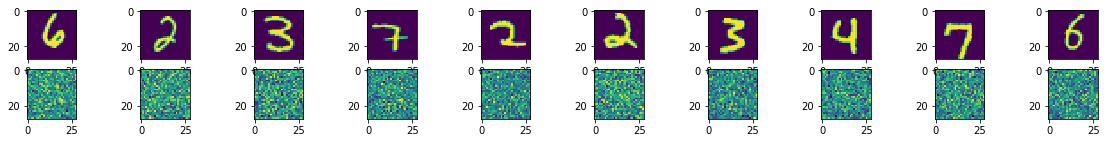

In [11]:
images, labels = next(iter(mnist_test))
noise_dim = 128

def get_noise_batch(batch_size):
  noise_shape = [batch_size, noise_dim]
  return tf.random.normal(noise_shape, dtype=images.dtype)

def get_label_batch(batch_size):
  label_shape = [batch_size]
  return tf.random.uniform(label_shape, maxval=10, dtype=labels.dtype)

logits = gan.discriminate(images)
noise = get_noise_batch(images.shape[0])
gen_images = gan.generate(noise)

num_images = 10
plt.rcParams['figure.figsize'] = (2*num_images, 2)
for i in range(num_images):
  plt.subplot(2, num_images, i+1)
  plt.imshow(images[i])
  plt.subplot(2, num_images, num_images+i+1)
  plt.imshow(gen_images[i])

Print the names, shapes, and other information about the variables in our little GAN model to get a rough idea of its structure.

In [12]:
print(snt.format_variables(gan.variables))

Variable                                                                         Shape      Type     Trainable  Device
little_gan/discriminator/block_0/spectrally_normed_linear/b                      1024       float32  True       /job:localhost/replica:0/task:0/device:GPU:0
little_gan/discriminator/block_0/spectrally_normed_linear/spectral_normalizer/u  1x1024     float32  False      /job:localhost/replica:0/task:0/device:GPU:0
little_gan/discriminator/block_0/spectrally_normed_linear/w                      784x1024   float32  True       /job:localhost/replica:0/task:0/device:GPU:0
little_gan/discriminator/block_1/spectrally_normed_linear/b                      1024       float32  True       /job:localhost/replica:0/task:0/device:GPU:0
little_gan/discriminator/block_1/spectrally_normed_linear/spectral_normalizer/u  1x1024     float32  False      /job:localhost/replica:0/task:0/device:GPU:0
little_gan/discriminator/block_1/spectrally_normed_linear/w                      1024x1024  floa

## Training the model

To train the model we need a loss function for both the discriminator and generator, as well as an optimizer.

We'll optimize the discriminator via the "hinge loss", defined by the function `hinge_loss_disc`. The generator simply maximizes the discriminator's error via a linear loss given by `loss_gen`.

For the optimizer, we'll use the "Adam" optimizer (`snt.optimizers.Adam`). To compute gradients we'll use a `tf.GradientTape` which allows us to selectively record gradients only for the computation we want to back propagate through.

We'll put all of this together below in a Sonnet Module called `GANOptimizer`, which takes as input the GAN to be optimized:

In [0]:
def hinge_loss_disc(preds_real, preds_gen):
  loss_real = tf.reduce_mean(tf.nn.relu(1. - preds_real))
  loss_gen = tf.reduce_mean(tf.nn.relu(1. + preds_gen))
  return loss_real + loss_gen

def loss_gen(preds_gen):
  return -tf.reduce_mean(preds_gen)

class GANOptimizer(snt.Module):

  def __init__(self,
               gan,
               gen_batch_size=100,
               disc_lr=2e-4,
               gen_lr=5e-5,
               loss_type='hinge',
               num_epochs=100,
               decay_lr_start_epoch=50,
               decay_disc_lr=True,
               decay_gen_lr=True,
               name=None):
    super().__init__(name=name)
    self.gan = gan
    self.gen_batch_size = gen_batch_size
    self.init_disc_lr = disc_lr
    self.init_gen_lr = gen_lr
    self.disc_lr = tf.Variable(
        disc_lr, trainable=False, name='disc_lr', dtype=tf.float32)
    self.gen_lr = tf.Variable(
        gen_lr, trainable=False, name='gen_lr', dtype=tf.float32)
    self.disc_opt = snt.optimizers.Adam(learning_rate=self.disc_lr, beta1=0.)
    self.gen_opt = snt.optimizers.Adam(learning_rate=self.gen_lr, beta1=0.)
    self.num_epochs = tf.constant(num_epochs, dtype=tf.int32)
    self.decay_lr_start_epoch = tf.constant(decay_lr_start_epoch, dtype=tf.int32)
    self.decay_disc_lr = decay_disc_lr
    self.decay_gen_lr = decay_gen_lr

  def disc_step(self, images, labels, lr_mult=1.):
    """Updates the discriminator once on the given batch of (images, labels)."""
    del labels
    gan = self.gan
    with tf.GradientTape() as tape:
      gen_images = gan.generate(get_noise_batch(images.shape[0]))
      preds_real = gan.discriminate(images)
      preds_gen = gan.discriminate(gen_images)
      loss = hinge_loss_disc(preds_real, preds_gen)
    disc_params = gan.discriminator.trainable_variables
    disc_grads = tape.gradient(loss, disc_params)
    if self.decay_disc_lr:
      self.disc_lr.assign(self.init_disc_lr * lr_mult)
    self.disc_opt.apply(disc_grads, disc_params)
    return loss

  def gen_step(self, lr_mult=1.):
    """Updates the generator once."""
    gan = self.gan
    noise = get_noise_batch(self.gen_batch_size)
    with tf.GradientTape() as tape:
      gen_images = gan.generate(noise)
      preds_gen = gan.discriminate(gen_images)
      loss = loss_gen(preds_gen)
    gen_params = gan.generator.trainable_variables
    gen_grads = tape.gradient(loss, gen_params)
    if self.decay_gen_lr:
      self.gen_lr.assign(self.init_gen_lr * lr_mult)
    self.gen_opt.apply(gen_grads, gen_params)
    return loss

  def _get_lr_mult(self, epoch):
    # Linear decay to 0.
    decay_epoch = tf.cast(epoch - self.decay_lr_start_epoch, tf.float32)
    if decay_epoch < tf.constant(0, dtype=tf.float32):
      return tf.constant(1., dtype=tf.float32)
    num_decay_epochs = tf.cast(self.num_epochs - self.decay_lr_start_epoch,
                               dtype=tf.float32)
    return (num_decay_epochs - decay_epoch) / num_decay_epochs

  def step(self, train_batches, epoch):
    """Updates the discriminator and generator weights.

    The discriminator is updated `len(train_batches)` times and the generator is
    updated once.

    Args:
      train_batches: list of batches, where each item is an (image, label)
        tuple. The discriminator is updated on each of these batches.
      epoch: the epoch number, used to decide the learning rate multiplier for
        learning rate decay.

    Returns:
      loss: the generator loss.
      lr_mult: the computed learning rate multiplier.
    """
    lr_mult = self._get_lr_mult(epoch)
    for train_batch in train_batches:
      self.disc_step(*train_batch, lr_mult=lr_mult)
    return self.gen_step(lr_mult=lr_mult), lr_mult

In [14]:
import tqdm

num_epochs = 25
num_disc_steps = 2

# We'll turn the step function which updates our models into a tf.function using
# autograph. This makes training much faster. If debugging, you can turn this
# off by setting `debug = True`.
debug = False

optimizer = GANOptimizer(gan, num_epochs=num_epochs)
step = optimizer.step
if not debug:
  step = tf.function(step)

train_dataset = iter(mnist_shuffled)
num_examples = mnist_train_info.splits['train'].num_examples
total_batch_size_per_step = batch_size * num_disc_steps
steps_per_epoch = num_examples // total_batch_size_per_step

steps_with_progress = tqdm.tqdm(range(num_epochs * steps_per_epoch),
                                unit='images', unit_scale=batch_size,
                                position=0)

for step_num in steps_with_progress:
  epoch = tf.constant(int(step_num / steps_per_epoch))
  train_batches = [train_dataset.next() for _ in range(num_disc_steps)]
  loss, lr_mult = step(train_batches, epoch)

  if step_num and (step_num % steps_per_epoch == 0):
    tqdm.tqdm.write(
        '\nEpoch = {}/{} (lr_mult = {:0.02f}, loss = {}) done.'.format(
            epoch.numpy(), num_epochs, lr_mult.numpy(), loss.numpy()))

print('Epoch = {}/{} (lr_mult = {:0.02f}, loss = {}) done.'.format(
    num_epochs, num_epochs, lr_mult.numpy(), loss.numpy()))

  0%|          | 0/750000 [00:00<?, ?images/s]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
  4%|▍         | 31300/750000 [00:19<01:15, 9470.95images/s]


Epoch = 1/25 (lr_mult = 1.00, loss = 0.016450781375169754) done.


  8%|▊         | 62500/750000 [00:21<00:56, 12207.04images/s]


Epoch = 2/25 (lr_mult = 1.00, loss = 0.04956576228141785) done.


 12%|█▏        | 92400/750000 [00:24<00:53, 12197.78images/s]


Epoch = 3/25 (lr_mult = 1.00, loss = 0.10389317572116852) done.


 16%|█▋        | 122200/750000 [00:26<00:51, 12084.79images/s]


Epoch = 4/25 (lr_mult = 1.00, loss = 0.051943909376859665) done.


 20%|██        | 151900/750000 [00:28<00:49, 12153.37images/s]


Epoch = 5/25 (lr_mult = 1.00, loss = -0.21330127120018005) done.


 24%|██▍       | 181800/750000 [00:31<00:47, 11858.25images/s]


Epoch = 6/25 (lr_mult = 1.00, loss = 0.15133343636989594) done.


 28%|██▊       | 211500/750000 [00:33<00:44, 12015.89images/s]


Epoch = 7/25 (lr_mult = 1.00, loss = 0.2119884043931961) done.


 32%|███▏      | 242500/750000 [00:36<00:41, 12089.66images/s]


Epoch = 8/25 (lr_mult = 1.00, loss = 0.25304022431373596) done.


 36%|███▋      | 272400/750000 [00:38<00:39, 11972.72images/s]


Epoch = 9/25 (lr_mult = 1.00, loss = 0.31501442193984985) done.


 40%|████      | 302100/750000 [00:41<00:38, 11631.19images/s]


Epoch = 10/25 (lr_mult = 1.00, loss = 0.3819904327392578) done.


 44%|████▍     | 331900/750000 [00:43<00:35, 11762.71images/s]


Epoch = 11/25 (lr_mult = 1.00, loss = 0.359415739774704) done.


 48%|████▊     | 361700/750000 [00:46<00:33, 11701.33images/s]


Epoch = 12/25 (lr_mult = 1.00, loss = 0.3620455861091614) done.


 52%|█████▏    | 391300/750000 [00:48<00:30, 11574.55images/s]


Epoch = 13/25 (lr_mult = 1.00, loss = 0.34004005789756775) done.


 56%|█████▋    | 422000/750000 [00:51<00:27, 11761.06images/s]


Epoch = 14/25 (lr_mult = 1.00, loss = 0.4108557105064392) done.


 60%|██████    | 451400/750000 [00:53<00:25, 11703.31images/s]


Epoch = 15/25 (lr_mult = 1.00, loss = 0.4520989954471588) done.


 64%|██████▍   | 481900/750000 [00:56<00:23, 11577.90images/s]


Epoch = 16/25 (lr_mult = 1.00, loss = 0.46710577607154846) done.


 68%|██████▊   | 511200/750000 [00:58<00:20, 11707.29images/s]


Epoch = 17/25 (lr_mult = 1.00, loss = 0.4239480197429657) done.


 72%|███████▏  | 541700/750000 [01:01<00:17, 12108.87images/s]


Epoch = 18/25 (lr_mult = 1.00, loss = 0.40935561060905457) done.


 76%|███████▌  | 571500/750000 [01:03<00:15, 11730.40images/s]


Epoch = 19/25 (lr_mult = 1.00, loss = 0.46318596601486206) done.


 80%|████████  | 601400/750000 [01:06<00:12, 12025.96images/s]


Epoch = 20/25 (lr_mult = 1.00, loss = 0.45752182602882385) done.


 84%|████████▍ | 632400/750000 [01:08<00:09, 11889.06images/s]


Epoch = 21/25 (lr_mult = 1.00, loss = 0.3791620135307312) done.


 88%|████████▊ | 662100/750000 [01:11<00:07, 11857.17images/s]


Epoch = 22/25 (lr_mult = 1.00, loss = 0.2888197600841522) done.


 92%|█████████▏| 691900/750000 [01:13<00:04, 12035.37images/s]


Epoch = 23/25 (lr_mult = 1.00, loss = 0.4309738874435425) done.


 96%|█████████▌| 721800/750000 [01:16<00:02, 11965.87images/s]


Epoch = 24/25 (lr_mult = 1.00, loss = 0.28471168875694275) done.


100%|██████████| 750000/750000 [01:18<00:00, 9546.01images/s] 

Epoch = 25/25 (lr_mult = 1.00, loss = 0.1431596875190735) done.


## Evaluating the model

Having trained our little GAN, let's check what its generated images look like now.

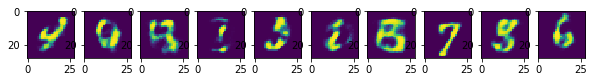

In [15]:
num_images = 10
noise = get_noise_batch(num_images)
gen_images = gan.generate(noise)
plt.rcParams['figure.figsize'] = (num_images, 1)
for i in range(num_images):
  plt.subplot(1, num_images, i+1)
  plt.imshow(gen_images[i])

Whew, those should already look much closer to actual handwritten digits! But there's still a ways to go. There are many potential ways to improve the results further, including (roughly in order of implementation difficulty):

* Train the model for more steps (e.g., try setting `num_epochs = 100` or higher).
* Add learning rate decay to make the step size smaller after a certain amount of time. (For example, try `optimizer = GANOptimizer(num_epochs=100, decay_lr_start_epoch=50)` to begin decaying the learning rate halfway through training.)
* Increase the size of the model -- make it deeper (`num_layers=4`) and/or wider (`embed_dim=2048`).
* Tweak the learning hyperparameters, such as the discriminator & generator learning rates or the training batch size.
* Make the models **convolutional**, using `snt.Conv2D` layers to process the inputs and outputs. The generator and discriminator defined above use MLPs, which naively treat the digit images as flat vectors.
* Make the model **conditional** on labels by feeding the digit label (e.g., "7") into the generator and discriminator. (See [1, 2] for some ideas on how to do this.)

[1] M. Mirza and S. Osindero. [*Conditional Generative Adversarial Networks*](https://arxiv.org/abs/1411.1784). *arXiv:1411.1784*, 2014.

[2] T. Miyato and M. Koyama. [*cGANs with Projection Discriminator*](https://arxiv.org/abs/1802.05637). *arXiv:1802.05637*, 2018.